
# Lap Time Model (Option A)
Clean Pace + Tyre Wear + Track Evolution + Traffic



# Load data


In [25]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

In [26]:

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [27]:

from pathlib import Path

csv_candidates = [Path('fastf1_lap_dataset.csv'), Path('models/fastf1_lap_dataset.csv')]
csv_path = next((p for p in csv_candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError('fastf1_lap_dataset.csv not found')

df = pd.read_csv(csv_path)
print(df.shape)


(198633, 29)



# Filter normal laps + robust outliers


In [28]:

df = df.copy()

for col in ['safety_car_this_lap', 'virtual_sc_this_lap', 'is_pit']:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(bool)
    else:
        df[col] = False

normal_mask = (
    df['lap_time_s'].notna() &
    (~df['safety_car_this_lap']) &
    (~df['virtual_sc_this_lap']) &
    (~df['is_pit'])
)

df_norm = df[normal_mask].copy()

window = 5
mad_thresh = 6.0

def rolling_mad_mask(grp):
    grp = grp.sort_values('lap_number')
    x = grp['lap_time_s'].astype(float)
    med = x.rolling(window, center=True, min_periods=3).median()
    mad = (x - med).abs().rolling(window, center=True, min_periods=3).median()
    mad = mad.replace(0, np.nan)
    keep = (x - med).abs() <= (mad_thresh * mad)
    keep = keep.fillna(True)
    keep.index = grp.index
    return keep

keep_mask = (
    df_norm
    .groupby(['session_key', 'driver_id'], group_keys=False)
    .apply(rolling_mad_mask)
)

df_norm = df_norm[keep_mask].copy()
print(df_norm.shape)


(141946, 29)


/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_82538/252515619.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rolling_mad_mask)


In [29]:
# Pit loss stats by circuit (mean/std + floor/excess for skewed sampling)
# Treat consecutive pit laps as a single stop (pit-in + pit-out).
pit_laps = df.copy()
pit_laps = pit_laps[(pit_laps['is_pit']) & pit_laps['lap_time_s'].notna()].copy()
pit_laps = pit_laps[(~pit_laps['safety_car_this_lap']) & (~pit_laps['virtual_sc_this_lap'])].copy()

baseline_source = df[(~df['is_pit']) & df['lap_time_s'].notna() & (~df['safety_car_this_lap']) & (~df['virtual_sc_this_lap'])].copy()
session_median = baseline_source.groupby('session_key')['lap_time_s'].median()

pit_laps = pit_laps.sort_values(['session_key', 'driver_id', 'lap_number'])

def assign_pit_group(sub):
    return sub['lap_number'].diff().ne(1).cumsum()

pit_laps['pit_group'] = pit_laps.groupby(['session_key', 'driver_id'], group_keys=False).apply(assign_pit_group)

pit_stops = (
    pit_laps.groupby(['session_key', 'driver_id', 'circuit_id', 'pit_group'])
    .agg(
        pit_lap_time_sum=('lap_time_s', 'sum'),
        pit_lap_count=('lap_time_s', 'count'),
        pit_in_lap=('lap_number', 'min'),
    )
    .reset_index()
)

pit_stops = pit_stops[pit_stops['pit_lap_count'] == 2].copy()
pit_stops['prev_lap'] = pit_stops['pit_in_lap'] - 1

prev_laps = baseline_source[['session_key', 'driver_id', 'lap_number', 'lap_time_s']].copy()
prev_laps = prev_laps.rename(columns={'lap_number': 'prev_lap', 'lap_time_s': 'prev_lap_time'})

pit_stops = pit_stops.merge(
    prev_laps,
    on=['session_key', 'driver_id', 'prev_lap'],
    how='left',
)

pit_stops['prev_lap_time'] = pit_stops['prev_lap_time'].fillna(
    pit_stops['session_key'].map(session_median)
)

pit_stops['pit_loss_s'] = pit_stops['pit_lap_time_sum'] - (
    pit_stops['pit_lap_count'] * pit_stops['prev_lap_time']
)

pit_df = pit_stops.copy()
pit_df['pit_loss_s'] = pd.to_numeric(pit_df['pit_loss_s'], errors='coerce')
pit_df = pit_df[pit_df['pit_loss_s'].notna()].copy()
pit_df = pit_df[pit_df['pit_loss_s'] > 0].copy()

def drop_pit_outliers(grp):
    x = grp['pit_loss_s'].astype(float)
    med = float(np.median(x))
    mad = float(np.median(np.abs(x - med)))
    if mad <= 0:
        return grp
    scale = 1.4826 * mad
    keep = np.abs(x - med) <= (4.0 * scale)
    return grp.loc[keep]

pit_df = pit_df.groupby('circuit_id', group_keys=False).apply(drop_pit_outliers)

# Floor per circuit (p5) and excess distribution
pit_floor = pit_df.groupby('circuit_id')['pit_loss_s'].quantile(0.05)
pit_df['pit_loss_floor'] = pit_df['circuit_id'].map(pit_floor)
pit_df['pit_excess_s'] = (pit_df['pit_loss_s'] - pit_df['pit_loss_floor']).clip(lower=0.0)

pit_loss_stats = (
    pit_df.groupby('circuit_id')
    .agg(
        pit_loss_floor=('pit_loss_floor', 'first'),
        pit_excess_mean=('pit_excess_s', 'mean'),
        pit_excess_std=('pit_excess_s', 'std'),
        pit_loss_mean=('pit_loss_s', 'mean'),
        pit_loss_std=('pit_loss_s', 'std'),
        pit_loss_count=('pit_loss_s', 'count'),
    )
    .sort_values('pit_loss_mean', ascending=False)
)

pit_loss_map = pit_loss_stats[[
    'pit_loss_floor',
    'pit_excess_mean',
    'pit_excess_std',
    'pit_loss_mean',
    'pit_loss_std',
]].to_dict('index')
pit_loss_stats


/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_82538/785576228.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pit_laps['pit_group'] = pit_laps.groupby(['session_key', 'driver_id'], group_keys=False).apply(assign_pit_group)
/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_82538/785576228.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pit_df = pit_df.groupby('circuit_id', group_keys=Fa

,pit_loss_floor,pit_excess_mean,pit_excess_std,pit_loss_mean,pit_loss_std,pit_loss_count
circuit_id,,,,,,
imola,25.03250,3.063033,2.439807,27.977363,2.665918,91
portimão,24.26080,3.737542,3.608533,27.963289,3.649258,45
lusail,23.92450,3.098425,2.370192,26.957075,2.476981,106
marina_bay,20.41050,5.860471,4.790595,26.217804,4.868991,51
singapore,21.15970,4.680387,2.456291,25.712641,2.755975,39
monza,21.60970,2.743517,1.972433,24.301524,2.066550,124
sochi,19.63240,4.296530,2.510973,23.868444,2.644260,63
le_castellet,19.66675,4.216795,2.658723,23.823197,2.769556,66
nürburgring,20.23720,2.773400,2.857158,22.984294,2.886200,17



# Feature engineering and stint statistics


In [30]:
circuit_baseline = (
    df_norm
    .groupby('circuit_id')['lap_time_s']
    .median()
    .reset_index()
    .rename(columns={'lap_time_s': 'circuit_median_lap'})
)

df_norm = df_norm.merge(circuit_baseline, on='circuit_id', how='left')
df_norm['lap_delta_s'] = df_norm['lap_time_s'] - df_norm['circuit_median_lap']

circuit_median_map = circuit_baseline.set_index('circuit_id')['circuit_median_lap'].to_dict()
global_median_lap = float(circuit_baseline['circuit_median_lap'].median())


df_norm['gap_ahead'] = pd.to_numeric(df_norm.get('gap_to_ahead_s', 10.0), errors='coerce').fillna(10.0)
df_norm['gap_ahead'] = df_norm['gap_ahead'].clip(0, 10)

df_norm['drs'] = df_norm.get('drs_enabled', False).fillna(False).astype(int)

has_rain = df_norm.get('has_rain', 0).fillna(0).astype(int)
if 'rainfall' in df_norm.columns:
    rainfall = pd.to_numeric(df_norm['rainfall'], errors='coerce').fillna(0.0)
else:
    rainfall = 0

df_norm['wet'] = ((has_rain > 0) | (rainfall > 0)).astype(int)

if 'total_race_laps' not in df_norm.columns:
    df_norm['total_race_laps'] = df_norm.groupby('session_key')['lap_number'].transform('max')
else:
    df_norm['total_race_laps'] = df_norm['total_race_laps'].fillna(
        df_norm.groupby('session_key')['lap_number'].transform('max')
    )

df_norm['laps_remaining'] = df_norm['total_race_laps'] - df_norm['lap_number']
df_norm['lap_number_norm'] = df_norm['lap_number'] / df_norm['total_race_laps']
df_norm['laps_remaining_norm'] = df_norm['laps_remaining'] / df_norm['total_race_laps']

df_norm['laps_on_current_tyre'] = pd.to_numeric(df_norm['laps_on_current_tyre'], errors='coerce').fillna(1).clip(lower=1)

track_cols = ['track_temperature', 'air_temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction']
for col in track_cols:
    if col not in df_norm.columns:
        df_norm[col] = 0.0
    df_norm[col] = pd.to_numeric(df_norm[col], errors='coerce').fillna(0.0)


def add_stint_id(grp):
    grp = grp.sort_values('lap_number')
    laps = grp['laps_on_current_tyre'].to_numpy()
    reset = np.zeros(len(laps), dtype=bool)
    reset[0] = True
    reset[1:] = laps[1:] <= laps[:-1]
    stint_id = np.cumsum(reset)
    grp = grp.copy()
    grp['stint_id'] = stint_id
    return grp


df_norm = df_norm.groupby(['session_key', 'driver_id'], group_keys=False).apply(add_stint_id)

stint_lengths = (
    df_norm
    .groupby(['session_key', 'driver_id', 'stint_id'])
    .size()
    .reset_index(name='stint_len')
)

stint_meta = df_norm[['session_key', 'driver_id', 'stint_id', 'circuit_id', 'tyre_compound']].drop_duplicates()
stint_lengths = stint_lengths.merge(stint_meta, on=['session_key', 'driver_id', 'stint_id'], how='left')

stint_stats = (
    stint_lengths
    .groupby(['circuit_id', 'tyre_compound'])['stint_len']
    .median()
    .reset_index()
    .rename(columns={'stint_len': 'expected_stint_len'})
)

df_norm = df_norm.merge(stint_stats, on=['circuit_id', 'tyre_compound'], how='left')

expected_global = float(df_norm['expected_stint_len'].median() or 15)
df_norm['expected_stint_len'] = df_norm['expected_stint_len'].fillna(expected_global)

df_norm['tyre_age'] = df_norm['laps_on_current_tyre']
df_norm['age_norm'] = df_norm['tyre_age'] / df_norm['expected_stint_len']
df_norm['age_over'] = (df_norm['tyre_age'] - df_norm['expected_stint_len']).clip(lower=0)
df_norm['age_over_norm'] = df_norm['age_over'] / df_norm['expected_stint_len']

clean_gap_threshold = 2.5
df_norm['is_clean_air'] = (df_norm['gap_ahead'] >= clean_gap_threshold) & (df_norm['drs'] == 0)

print(df_norm[['lap_time_s', 'gap_ahead', 'drs', 'is_clean_air']].head())


   lap_time_s  gap_ahead  drs  is_clean_air
0     108.819      0.613    0         False
1     108.315      0.924    0         False
2     106.648      1.075    0         False
3     107.209      1.224    0         False
4     107.419      1.656    0         False


/var/folders/3t/lccpd1j15071g5nr0s6sjcr80000gn/T/ipykernel_82538/871208319.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_norm = df_norm.groupby(['session_key', 'driver_id'], group_keys=False).apply(add_stint_id)



# Split by session_key


In [31]:

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_idx, test_idx = next(gss.split(df_norm, groups=df_norm['session_key']))
train_df = df_norm.iloc[train_idx].copy()
test_df = df_norm.iloc[test_idx].copy()

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = next(gss_val.split(train_df, groups=train_df['session_key']))
val_df = train_df.iloc[val_idx].copy()
train_df = train_df.iloc[train_idx].copy()

print(train_df.shape, val_df.shape, test_df.shape)


(101820, 44) (10785, 44) (29341, 44)



# Spline basis for track evolution


In [32]:

for df_part in [train_df, val_df, test_df]:
    df_part['lap_progress'] = df_part['lap_number'] / df_part['total_race_laps']

spline = SplineTransformer(n_knots=6, degree=3, include_bias=False)
spline.fit(train_df[['lap_progress']])


def add_spline_features(df_part, transformer):
    basis = transformer.transform(df_part[['lap_progress']])
    colnames = [f'lap_spline_{i}' for i in range(basis.shape[1])]
    for i, col in enumerate(colnames):
        df_part[col] = basis[:, i]
    return colnames


spline_cols = add_spline_features(train_df, spline)
add_spline_features(val_df, spline)
add_spline_features(test_df, spline)

print(spline_cols)


['lap_spline_0', 'lap_spline_1', 'lap_spline_2', 'lap_spline_3', 'lap_spline_4', 'lap_spline_5', 'lap_spline_6']



# Encoders and scalers


In [33]:

MIN_DRIVER_LAPS = 200
MIN_SESSION_LAPS = 200


def build_vocab(series, min_count=None):
    s = series.dropna().astype(str)
    if min_count is not None:
        counts = s.value_counts()
        keep = counts[counts >= min_count].index.tolist()
    else:
        keep = s.unique().tolist()
    vocab = {"__UNK__": 0}
    for val in keep:
        if val == "__UNK__":
            continue
        vocab[val] = len(vocab)
    return vocab


def encode_series(series, vocab):
    return series.astype(str).map(lambda v: vocab.get(v, vocab["__UNK__"])).astype(int)


cat_cols = ['driver_id', 'team_id', 'circuit_id', 'year', 'session_key', 'tyre_compound']
cat_vocabs = {
    'driver_id': build_vocab(train_df['driver_id'], min_count=MIN_DRIVER_LAPS),
    'team_id': build_vocab(train_df['team_id']),
    'circuit_id': build_vocab(train_df['circuit_id']),
    'year': build_vocab(train_df['year']),
    'session_key': build_vocab(train_df['session_key'], min_count=MIN_SESSION_LAPS),
    'tyre_compound': build_vocab(train_df['tyre_compound']),
}

for col in cat_cols:
    for df_part in [train_df, val_df, test_df]:
        df_part[col + '_id'] = encode_series(df_part[col], cat_vocabs[col])

driver_counts = train_df['driver_id'].value_counts().to_dict()
driver_shrink_k = 2000.0
for df_part in [train_df, val_df, test_df]:
    counts = df_part['driver_id'].map(driver_counts).fillna(0)
    df_part['driver_weight'] = counts / (counts + driver_shrink_k)

weather_cols = ['track_temperature', 'air_temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction', 'wet']
weather_scaler = StandardScaler()
weather_scaler.fit(train_df[weather_cols])


def add_scaled_weather(df_part):
    scaled = weather_scaler.transform(df_part[weather_cols])
    for i, col in enumerate(weather_cols):
        df_part[col + '_scaled'] = scaled[:, i]


for df_part in [train_df, val_df, test_df]:
    add_scaled_weather(df_part)

weather_scaled_cols = [c + '_scaled' for c in weather_cols]



# Datasets


In [34]:

class CleanPaceDataset(Dataset):
    def __init__(self, df_part, spline_cols, weather_cols_scaled):
        self.driver = df_part['driver_id_id'].to_numpy()
        self.team = df_part['team_id_id'].to_numpy()
        self.circuit = df_part['circuit_id_id'].to_numpy()
        self.year = df_part['year_id'].to_numpy()
        self.session = df_part['session_key_id'].to_numpy()
        self.compound = df_part['tyre_compound_id'].to_numpy()
        self.driver_weight = df_part['driver_weight'].to_numpy(dtype=np.float32)
        self.laps_remaining_norm = df_part['laps_remaining_norm'].to_numpy(dtype=np.float32)
        self.tyre_age = df_part['tyre_age'].to_numpy(dtype=np.float32)
        self.age_norm = df_part['age_norm'].to_numpy(dtype=np.float32)
        self.age_over_norm = df_part['age_over_norm'].to_numpy(dtype=np.float32)
        self.expected_len = df_part['expected_stint_len'].to_numpy(dtype=np.float32)
        self.lap_spline = df_part[spline_cols].to_numpy(dtype=np.float32)
        self.weather = df_part[weather_cols_scaled].to_numpy(dtype=np.float32)
        self.target = df_part['lap_delta_s'].to_numpy(dtype=np.float32)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.driver[idx], dtype=torch.long),
            torch.tensor(self.team[idx], dtype=torch.long),
            torch.tensor(self.circuit[idx], dtype=torch.long),
            torch.tensor(self.year[idx], dtype=torch.long),
            torch.tensor(self.session[idx], dtype=torch.long),
            torch.tensor(self.compound[idx], dtype=torch.long),
            torch.tensor(self.driver_weight[idx], dtype=torch.float32),
            torch.tensor(self.laps_remaining_norm[idx], dtype=torch.float32),
            torch.tensor(self.tyre_age[idx], dtype=torch.float32),
            torch.tensor(self.age_norm[idx], dtype=torch.float32),
            torch.tensor(self.age_over_norm[idx], dtype=torch.float32),
            torch.tensor(self.expected_len[idx], dtype=torch.float32),
            torch.tensor(self.lap_spline[idx], dtype=torch.float32),
            torch.tensor(self.weather[idx], dtype=torch.float32),
            torch.tensor(self.target[idx], dtype=torch.float32),
        )


class TrafficDataset(Dataset):
    def __init__(self, df_part, target_penalty):
        self.circuit = df_part['circuit_id_id'].to_numpy()
        self.gap_ahead = df_part['gap_ahead'].to_numpy(dtype=np.float32)
        self.drs = df_part['drs'].to_numpy(dtype=np.float32)
        self.target = target_penalty.astype(np.float32)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.circuit[idx], dtype=torch.long),
            torch.tensor(self.gap_ahead[idx], dtype=torch.float32),
            torch.tensor(self.drs[idx], dtype=torch.float32),
            torch.tensor(self.target[idx], dtype=torch.float32),
        )


clean_train_df = train_df[train_df['is_clean_air']].copy()
clean_val_df = val_df[val_df['is_clean_air']].copy()
clean_test_df = test_df[test_df['is_clean_air']].copy()

clean_train = CleanPaceDataset(clean_train_df, spline_cols, weather_scaled_cols)
clean_val = CleanPaceDataset(clean_val_df, spline_cols, weather_scaled_cols)
clean_test = CleanPaceDataset(clean_test_df, spline_cols, weather_scaled_cols)

batch_size = 512
clean_train_loader = DataLoader(clean_train, batch_size=batch_size, shuffle=True, drop_last=False)
clean_val_loader = DataLoader(clean_val, batch_size=batch_size, shuffle=False, drop_last=False)
clean_test_loader = DataLoader(clean_test, batch_size=batch_size, shuffle=False, drop_last=False)



# Clean pace model


In [35]:

class CleanPaceModel(nn.Module):
    def __init__(self, vocab_sizes, spline_dim, weather_dim):
        super().__init__()
        self.driver_emb = nn.Embedding(vocab_sizes['driver'], 16)
        self.team_emb = nn.Embedding(vocab_sizes['team'], 8)
        self.circuit_emb = nn.Embedding(vocab_sizes['circuit'], 12)
        self.year_emb = nn.Embedding(vocab_sizes['year'], 4)
        self.session_emb = nn.Embedding(vocab_sizes['session'], 8)
        self.compound_emb = nn.Embedding(vocab_sizes['compound'], 4)

        base_in = 16 + 8 + 12 + 4 + 8
        self.base_linear = nn.Linear(base_in, 1)

        self.fuel_linear = nn.Linear(12, 1)
        self.track_linear = nn.Linear(8, spline_dim)

        tyre_in = 4 + 12 + weather_dim + 1
        self.tyre_mlp = nn.Sequential(
            nn.Linear(tyre_in, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
        )

        self.weather_mlp = nn.Sequential(
            nn.Linear(weather_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )

        self.age_norm_weight = nn.Parameter(torch.tensor(0.0))
        self.age_over_weight = nn.Parameter(torch.tensor(0.0))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, batch):
        (
            driver_id, team_id, circuit_id, year_id, session_id, compound_id, driver_weight,
            laps_remaining_norm, tyre_age, age_norm, age_over_norm, expected_len, lap_spline, weather
        ) = batch

        driver_emb_raw = self.driver_emb(driver_id)
        unk_id = torch.zeros_like(driver_id)
        driver_emb_unk = self.driver_emb(unk_id)
        w = driver_weight.unsqueeze(1).clamp(0.0, 1.0)
        driver_emb = w * driver_emb_raw + (1.0 - w) * driver_emb_unk
        team_emb = self.team_emb(team_id)
        circuit_emb = self.circuit_emb(circuit_id)
        year_emb = self.year_emb(year_id)
        session_emb = self.session_emb(session_id)
        compound_emb = self.compound_emb(compound_id)

        base = self.base_linear(torch.cat([driver_emb, team_emb, circuit_emb, year_emb, session_emb], dim=1)).squeeze(1)

        fuel_k = torch.nn.functional.softplus(self.fuel_linear(circuit_emb).squeeze(1))
        fuel = fuel_k * laps_remaining_norm

        track_weights = self.track_linear(session_emb)
        track_evo = (lap_spline * track_weights).sum(dim=1)

        expected_len = torch.clamp(expected_len, min=1e-6)
        tyre_context = torch.cat([compound_emb, circuit_emb, weather, expected_len.unsqueeze(1)], dim=1)
        tyre_params = self.tyre_mlp(tyre_context)
        a = torch.nn.functional.softplus(tyre_params[:, 0])
        b = torch.nn.functional.softplus(tyre_params[:, 1])
        c = torch.nn.functional.softplus(tyre_params[:, 2])
        tau = torch.nn.functional.softplus(tyre_params[:, 3])
        age_term = a * tyre_age + b * (tyre_age ** 2)
        knee = torch.nn.functional.softplus(tyre_age - tau)
        tyre_deg = age_term + c * (knee ** 2)

        extra_age = torch.nn.functional.softplus(self.age_norm_weight) * age_norm
        extra_over = torch.nn.functional.softplus(self.age_over_weight) * age_over_norm

        weather_term = self.weather_mlp(weather).squeeze(1)

        pred = base + fuel + track_evo + tyre_deg + weather_term + extra_age + extra_over + self.bias
        return pred


vocab_sizes = {
    'driver': len(cat_vocabs['driver_id']) + 1,
    'team': len(cat_vocabs['team_id']) + 1,
    'circuit': len(cat_vocabs['circuit_id']) + 1,
    'year': len(cat_vocabs['year']) + 1,
    'session': len(cat_vocabs['session_key']) + 1,
    'compound': len(cat_vocabs['tyre_compound']) + 1,
}

clean_model = CleanPaceModel(vocab_sizes, spline_dim=len(spline_cols), weather_dim=len(weather_scaled_cols))

print(clean_model)


CleanPaceModel(
  (driver_emb): Embedding(43, 16)
  (team_emb): Embedding(21, 8)
  (circuit_emb): Embedding(37, 12)
  (year_emb): Embedding(10, 4)
  (session_emb): Embedding(141, 8)
  (compound_emb): Embedding(10, 4)
  (base_linear): Linear(in_features=48, out_features=1, bias=True)
  (fuel_linear): Linear(in_features=12, out_features=1, bias=True)
  (track_linear): Linear(in_features=8, out_features=7, bias=True)
  (tyre_mlp): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
  (weather_mlp): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)



# Train clean pace model


In [36]:

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
clean_model = clean_model.to(device)

optimizer = torch.optim.Adam(clean_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.SmoothL1Loss()

max_epochs = 10


def run_epoch(model, loader, train=False):
    model.train(train)
    total_loss = 0.0
    n = 0
    for batch in loader:
        batch = [b.to(device) for b in batch]
        *features, target = batch
        pred = model(features)
        loss = criterion(pred, target)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * target.size(0)
        n += target.size(0)
    return total_loss / max(n, 1)


for epoch in range(max_epochs):
    train_loss = run_epoch(clean_model, clean_train_loader, train=True)
    val_loss = run_epoch(clean_model, clean_val_loader, train=False)
    print(f'Epoch {epoch+1}/{max_epochs} - train: {train_loss:.4f} val: {val_loss:.4f}')


Epoch 1/10 - train: 124.4847 val: 12.7518
Epoch 2/10 - train: 6.5437 val: 3.1837
Epoch 3/10 - train: 2.5281 val: 2.5123
Epoch 4/10 - train: 2.0734 val: 2.3972
Epoch 5/10 - train: 1.8966 val: 2.3777
Epoch 6/10 - train: 1.7597 val: 2.3867
Epoch 7/10 - train: 1.6341 val: 2.4201
Epoch 8/10 - train: 1.5119 val: 2.4698
Epoch 9/10 - train: 1.4017 val: 2.4473
Epoch 10/10 - train: 1.3046 val: 2.4250



# Clean model evaluation


In [37]:


def predict_clean(model, loader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) for b in batch]
            *features, target = batch
            pred = model(features)
            preds.append(pred.cpu().numpy())
            targets.append(target.cpu().numpy())
    return np.concatenate(preds), np.concatenate(targets)


clean_pred_test, clean_target_test = predict_clean(clean_model, clean_test_loader)
rmse = np.sqrt(mean_squared_error(clean_target_test, clean_pred_test))
mae = mean_absolute_error(clean_target_test, clean_pred_test)
print(f'Clean-air RMSE: {rmse:.3f} | MAE: {mae:.3f}')

base_lap = clean_test_df['circuit_median_lap'].to_numpy(dtype=float)
abs_pred = clean_pred_test + base_lap
abs_rmse = float(np.sqrt(mean_squared_error(clean_test_df['lap_time_s'].to_numpy(), abs_pred)))
abs_mae = float(mean_absolute_error(clean_test_df['lap_time_s'].to_numpy(), abs_pred))
print(f'Clean-air RMSE (abs): {abs_rmse:.3f} | MAE (abs): {abs_mae:.3f}')


Clean-air RMSE: 3.620 | MAE: 1.953
Clean-air RMSE (abs): 3.620 | MAE (abs): 1.953



# Traffic model


In [38]:

class TrafficModel(nn.Module):
    def __init__(self, circuit_vocab_size):
        super().__init__()
        self.circuit_emb = nn.Embedding(circuit_vocab_size, 6)
        self.pmax_linear = nn.Linear(6, 1)
        self.g0_linear = nn.Linear(6, 1)
        self.s_raw = nn.Parameter(torch.tensor(0.5))
        self.drs_raw = nn.Parameter(torch.tensor(0.0))

    def forward(self, circuit_id, gap_ahead, drs):
        cemb = self.circuit_emb(circuit_id)
        pmax = torch.nn.functional.softplus(self.pmax_linear(cemb).squeeze(1))
        g0 = torch.nn.functional.softplus(self.g0_linear(cemb).squeeze(1))
        s = torch.nn.functional.softplus(self.s_raw) + 1e-3
        delta_drs = torch.sigmoid(self.drs_raw)
        penalty = pmax * torch.sigmoid((g0 - gap_ahead) / s)
        penalty = penalty * (1 - delta_drs * drs)
        return penalty


traffic_model = TrafficModel(vocab_sizes['circuit']).to(device)
traffic_optim = torch.optim.Adam(traffic_model.parameters(), lr=1e-3, weight_decay=1e-4)
traffic_loss = nn.SmoothL1Loss()



# Train traffic model on residuals


In [39]:


def get_clean_preds_for_df(df_part, model):
    dataset = CleanPaceDataset(df_part, spline_cols, weather_scaled_cols)
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    preds, targets = predict_clean(model, loader)
    return preds, targets


train_pred, train_target = get_clean_preds_for_df(train_df, clean_model)
val_pred, val_target = get_clean_preds_for_df(val_df, clean_model)

train_resid = train_target - train_pred
val_resid = val_target - val_pred

train_penalty = np.maximum(train_resid, 0.0)
val_penalty = np.maximum(val_resid, 0.0)

traffic_train = TrafficDataset(train_df, train_penalty)
traffic_val = TrafficDataset(val_df, val_penalty)

traffic_train_loader = DataLoader(traffic_train, batch_size=1024, shuffle=True)
traffic_val_loader = DataLoader(traffic_val, batch_size=1024, shuffle=False)

max_epochs = 5

for epoch in range(max_epochs):
    traffic_model.train()
    total = 0.0
    n = 0
    for circuit_id, gap_ahead, drs, target in traffic_train_loader:
        circuit_id = circuit_id.to(device)
        gap_ahead = gap_ahead.to(device)
        drs = drs.to(device)
        target = target.to(device)
        pred = traffic_model(circuit_id, gap_ahead, drs)
        loss = traffic_loss(pred, target)
        traffic_optim.zero_grad()
        loss.backward()
        traffic_optim.step()
        total += loss.item() * target.size(0)
        n += target.size(0)

    traffic_model.eval()
    val_total = 0.0
    val_n = 0
    with torch.no_grad():
        for circuit_id, gap_ahead, drs, target in traffic_val_loader:
            circuit_id = circuit_id.to(device)
            gap_ahead = gap_ahead.to(device)
            drs = drs.to(device)
            target = target.to(device)
            pred = traffic_model(circuit_id, gap_ahead, drs)
            loss = traffic_loss(pred, target)
            val_total += loss.item() * target.size(0)
            val_n += target.size(0)

    print(f'Epoch {epoch+1}/{max_epochs} - train: {total / max(n,1):.4f} val: {val_total / max(val_n,1):.4f}')


Epoch 1/5 - train: 1.0737 val: 2.1919
Epoch 2/5 - train: 1.0681 val: 2.1863
Epoch 3/5 - train: 1.0629 val: 2.1807
Epoch 4/5 - train: 1.0588 val: 2.1754
Epoch 5/5 - train: 1.0557 val: 2.1703



# End-to-end evaluation on normal laps


In [40]:


def predict_full(df_part):
    dataset = CleanPaceDataset(df_part, spline_cols, weather_scaled_cols)
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    clean_pred, target = predict_clean(clean_model, loader)

    traffic_dataset = TrafficDataset(df_part, np.zeros(len(df_part)))
    traffic_loader = DataLoader(traffic_dataset, batch_size=1024, shuffle=False)
    traffic_model.eval()
    traffic_preds = []
    with torch.no_grad():
        for circuit_id, gap_ahead, drs, _ in traffic_loader:
            pred = traffic_model(circuit_id.to(device), gap_ahead.to(device), drs.to(device))
            traffic_preds.append(pred.cpu().numpy())
    traffic_pred = np.concatenate(traffic_preds)

    base_lap = df_part["circuit_median_lap"].to_numpy(dtype=float)
    total_pred = base_lap + clean_pred + traffic_pred
    return target, clean_pred, traffic_pred, total_pred


full_target, clean_pred, traffic_pred, total_pred = predict_full(test_df)
rmse = np.sqrt(mean_squared_error(test_df["lap_time_s"].to_numpy(), total_pred))
mae = mean_absolute_error(test_df["lap_time_s"].to_numpy(), total_pred)
print(f'Full RMSE: {rmse:.3f} | MAE: {mae:.3f}')


Full RMSE: 6.278 | MAE: 2.555



# Diagnostics: tyre curves and traffic saturation


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/si

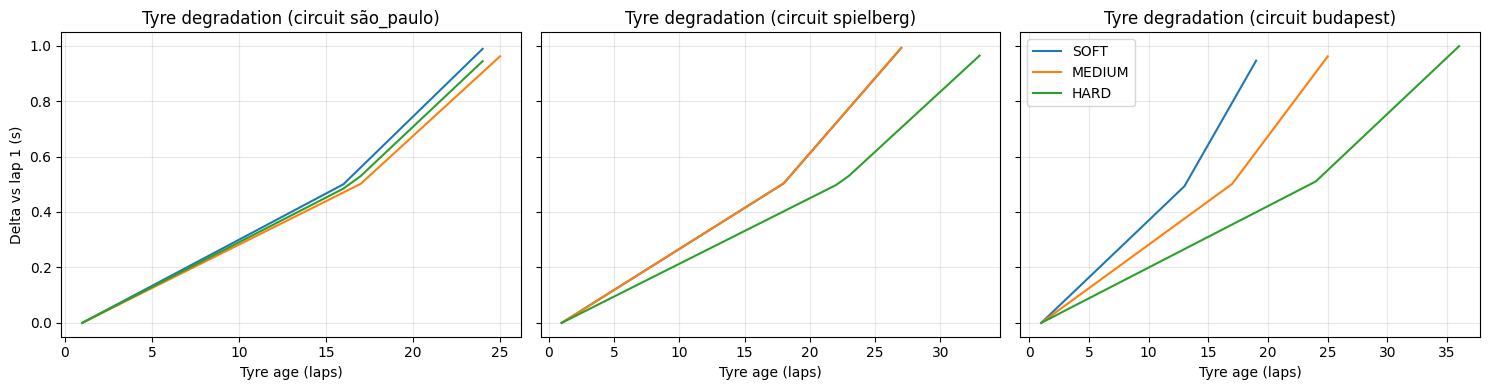

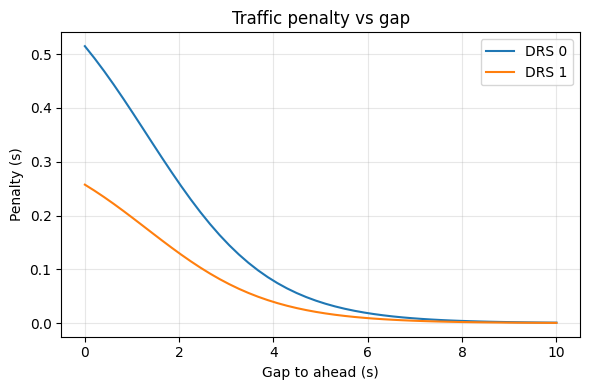

In [41]:

sample_driver = train_df['driver_id'].mode().iloc[0]
sample_team = train_df['team_id'].mode().iloc[0]

circuit_counts = train_df['circuit_id'].value_counts().head(3).index.tolist()
compounds = ['SOFT', 'MEDIUM', 'HARD']


def encode_single(row):
    row = row.copy()
    for col in cat_cols:
        row[col + '_id'] = encode_series(pd.Series([row[col]]), cat_vocabs[col]).iloc[0]
    weather_scaled = weather_scaler.transform(pd.DataFrame([row], columns=weather_cols))
    return row, weather_scaled[0]


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, circuit_id in zip(axes, circuit_counts):
    for compound in compounds:
        expected_val = stint_stats.loc[
            (stint_stats['circuit_id'] == circuit_id) & (stint_stats['tyre_compound'] == compound),
            'expected_stint_len'
        ]
        if expected_val.empty:
            expected_len = expected_global
        else:
            expected_len = float(expected_val.iloc[0])
        ages = np.arange(1, int(expected_len * 1.5) + 1)
        preds = []
        for age in ages:
            base_row = {
                'driver_id': sample_driver,
                'team_id': sample_team,
                'circuit_id': circuit_id,
                'year': train_df['year'].mode().iloc[0],
                'session_key': train_df['session_key'].mode().iloc[0],
                'tyre_compound': compound,
                'laps_remaining_norm': 0.5,
                'tyre_age': age,
                'age_norm': age / expected_len,
                'age_over_norm': max(0, age - expected_len) / expected_len,
                'lap_number': int(expected_len),
                'total_race_laps': int(expected_len),
                'track_temperature': train_df['track_temperature'].median(),
                'air_temperature': train_df['air_temperature'].median(),
                'humidity': train_df['humidity'].median(),
                'pressure': train_df['pressure'].median(),
                'wind_speed': train_df['wind_speed'].median(),
                'wind_direction': train_df['wind_direction'].median(),
                'wet': 0,
                'lap_progress': 0.5,
            }
            row, weather_scaled = encode_single(base_row)
            spline_basis = spline.transform([[row['lap_progress']]]).astype(np.float32)
            batch = (
                torch.tensor([row['driver_id_id']], dtype=torch.long, device=device),
                torch.tensor([row['team_id_id']], dtype=torch.long, device=device),
                torch.tensor([row['circuit_id_id']], dtype=torch.long, device=device),
                torch.tensor([row['year_id']], dtype=torch.long, device=device),
                torch.tensor([row['session_key_id']], dtype=torch.long, device=device),
                torch.tensor([row['tyre_compound_id']], dtype=torch.long, device=device),
                torch.tensor([1.0], dtype=torch.float32, device=device),
                torch.tensor([row['laps_remaining_norm']], dtype=torch.float32, device=device),
                torch.tensor([row['tyre_age']], dtype=torch.float32, device=device),
                torch.tensor([row['age_norm']], dtype=torch.float32, device=device),
                torch.tensor([row['age_over_norm']], dtype=torch.float32, device=device),
                torch.tensor([expected_len], dtype=torch.float32, device=device),
                torch.tensor(spline_basis, dtype=torch.float32, device=device),
                torch.tensor([weather_scaled], dtype=torch.float32, device=device),
            )
            with torch.no_grad():
                pred = clean_model(batch).cpu().item()
            preds.append(pred)
        preds = np.array(preds)
        preds = preds - preds[0]
        ax.plot(ages, preds, label=compound)
    ax.set_title(f'Tyre degradation (circuit {circuit_id})')
    ax.set_xlabel('Tyre age (laps)')
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel('Delta vs lap 1 (s)')
axes[-1].legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
example_circuit = circuit_counts[0]
example_circuit_id = encode_series(pd.Series([example_circuit]), cat_vocabs['circuit_id']).iloc[0]

gaps = np.linspace(0, 10, 50).astype(np.float32)
for drs in [0, 1]:
    circuit_ids = torch.tensor([example_circuit_id] * len(gaps), dtype=torch.long, device=device)
    gap_tensor = torch.tensor(gaps, dtype=torch.float32, device=device)
    drs_tensor = torch.tensor([drs] * len(gaps), dtype=torch.float32, device=device)
    with torch.no_grad():
        penalty = traffic_model(circuit_ids, gap_tensor, drs_tensor).cpu().numpy()
    ax.plot(gaps, penalty, label=f'DRS {drs}')

ax.set_title('Traffic penalty vs gap')
ax.set_xlabel('Gap to ahead (s)')
ax.set_ylabel('Penalty (s)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()



Export bundle


In [42]:
def prepare_features(df_in):
    df_feat = df_in.copy()
    for col in ['safety_car_this_lap', 'virtual_sc_this_lap', 'is_pit']:
        if col in df_feat.columns:
            df_feat[col] = df_feat[col].fillna(False).astype(bool)
        else:
            df_feat[col] = False

    df_feat['gap_ahead'] = pd.to_numeric(df_feat.get('gap_to_ahead_s', 10.0), errors='coerce').fillna(10.0)
    df_feat['gap_ahead'] = df_feat['gap_ahead'].clip(0, 10)
    df_feat['drs'] = df_feat.get('drs_enabled', False).fillna(False).astype(int)

    has_rain = df_feat.get('has_rain', 0).fillna(0).astype(int)
    if 'rainfall' in df_feat.columns:
        rainfall = pd.to_numeric(df_feat['rainfall'], errors='coerce').fillna(0.0)
    else:
        rainfall = 0
    df_feat['wet'] = ((has_rain > 0) | (rainfall > 0)).astype(int)

    if 'total_race_laps' not in df_feat.columns:
        df_feat['total_race_laps'] = df_feat.groupby('session_key')['lap_number'].transform('max')
    else:
        df_feat['total_race_laps'] = df_feat['total_race_laps'].fillna(
            df_feat.groupby('session_key')['lap_number'].transform('max')
        )

    df_feat['laps_remaining'] = df_feat['total_race_laps'] - df_feat['lap_number']
    df_feat['lap_number_norm'] = df_feat['lap_number'] / df_feat['total_race_laps']
    df_feat['laps_remaining_norm'] = df_feat['laps_remaining'] / df_feat['total_race_laps']

    df_feat['laps_on_current_tyre'] = pd.to_numeric(df_feat.get('laps_on_current_tyre', 1), errors='coerce').fillna(1).clip(lower=1)

    for col in track_cols:
        if col not in df_feat.columns:
            df_feat[col] = 0.0
        df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0.0)

    df_feat['lap_progress'] = df_feat['lap_number'] / df_feat['total_race_laps']
    basis = spline.transform(df_feat[['lap_progress']])
    for i, col in enumerate(spline_cols):
        df_feat[col] = basis[:, i]

    df_feat = df_feat.merge(stint_stats, on=['circuit_id', 'tyre_compound'], how='left')
    if 'expected_stint_len' not in df_feat.columns:
        base = None
        if 'expected_stint_len_x' in df_feat.columns:
            base = df_feat['expected_stint_len_x']
        if 'expected_stint_len_y' in df_feat.columns:
            base = df_feat['expected_stint_len_y'] if base is None else base.combine_first(df_feat['expected_stint_len_y'])
        df_feat['expected_stint_len'] = base if base is not None else np.nan
    df_feat['circuit_median_lap'] = df_feat['circuit_id'].map(circuit_median_map).fillna(global_median_lap)
    df_feat['expected_stint_len'] = df_feat['expected_stint_len'].fillna(expected_global)
    df_feat['tyre_age'] = df_feat['laps_on_current_tyre']
    df_feat['age_norm'] = df_feat['tyre_age'] / df_feat['expected_stint_len']
    df_feat['age_over'] = (df_feat['tyre_age'] - df_feat['expected_stint_len']).clip(lower=0)
    df_feat['age_over_norm'] = df_feat['age_over'] / df_feat['expected_stint_len']

    for col in cat_cols:
        df_feat[col + '_id'] = encode_series(df_feat[col], cat_vocabs[col])

    counts = df_feat['driver_id'].map(driver_counts).fillna(0)
    df_feat['driver_weight'] = counts / (counts + driver_shrink_k)

    scaled = weather_scaler.transform(df_feat[weather_cols])
    for i, col in enumerate(weather_cols):
        df_feat[col + '_scaled'] = scaled[:, i]

    return df_feat

In [43]:
# Calibrate race-level and lap-level noise from residuals
calib_feat = prepare_features(df_norm)
calib_target, calib_clean, calib_traffic, calib_total = predict_full(calib_feat)
calib_feat['pred_lap_time_s'] = calib_total
calib_feat['resid'] = calib_feat['lap_time_s'] - calib_feat['pred_lap_time_s']

form_means = calib_feat.groupby(['session_key', 'driver_id'])['resid'].mean()
form_center = float(np.median(form_means)) if len(form_means) else 0.0
form_mad = float(np.median(np.abs(form_means - form_center))) if len(form_means) else 0.0
noise_sigma_form = 1.4826 * form_mad

calib_feat['form_mean'] = calib_feat.groupby(['session_key', 'driver_id'])['resid'].transform('mean')
calib_feat['resid_detrended'] = calib_feat['resid'] - calib_feat['form_mean']

num = 0.0
den = 0.0
for _, grp in calib_feat.sort_values('lap_number').groupby(['session_key', 'driver_id']):
    r = grp['resid_detrended'].to_numpy()
    if len(r) < 2:
        continue
    num += float((r[1:] * r[:-1]).sum())
    den += float((r[:-1] ** 2).sum())
noise_rho = num / den if den > 0 else 0.0
noise_rho = float(np.clip(noise_rho, -0.95, 0.95))

sigma_r = float(np.nanstd(calib_feat['resid_detrended'].to_numpy()))
noise_sigma_eta = float(sigma_r * np.sqrt(max(1e-12, 1 - noise_rho ** 2)))

print(f'Noise calibration: sigma_form={noise_sigma_form:.4f}, rho={noise_rho:.4f}, sigma_eta={noise_sigma_eta:.4f}')


Noise calibration: sigma_form=1.2624, rho=0.5812, sigma_eta=4.2571


In [44]:

# Export compact inference bundle
import joblib

noise_sigma_form = float(locals().get('noise_sigma_form', 0.0))
noise_rho = float(locals().get('noise_rho', 0.0))
noise_sigma_eta = float(locals().get('noise_sigma_eta', 0.0))

bundle = {
    'clean_model_state_dict': {k: v.cpu() for k, v in clean_model.state_dict().items()},
    'traffic_model_state_dict': {k: v.cpu() for k, v in traffic_model.state_dict().items()},
    'cat_vocabs': cat_vocabs,
    'weather_scaler': weather_scaler,
    'spline': spline,
    'stint_stats': stint_stats,
    'expected_global': expected_global,
    'circuit_median_map': circuit_median_map,
    'global_median_lap': float(circuit_baseline['circuit_median_lap'].median()),
    'driver_counts': driver_counts,
    'driver_shrink_k': driver_shrink_k,
    'track_cols': track_cols,
    'weather_cols': weather_cols,
    'clean_gap_threshold': clean_gap_threshold,
    'noise_sigma_form': noise_sigma_form,
    'noise_rho': noise_rho,
    'noise_sigma_eta': noise_sigma_eta,
    'pit_loss_map': pit_loss_map,
    'pit_loss_stats': pit_loss_stats,
}

base_dir = Path.cwd()
if base_dir.name == 'models':
    base_dir = base_dir.parent
out_path = base_dir / 'models' / 'laptime_model_bundle.joblib'
joblib.dump(bundle, out_path)
print(f'Saved bundle to {out_path}')

Saved bundle to /Users/ekazuki/Documents/f1stuff/models/laptime_model_bundle.joblib



# Inference helper


In [45]:

@torch.no_grad()
def predict_lap_times(df_in):
    df_feat = prepare_features(df_in)
    dataset = CleanPaceDataset(df_feat, spline_cols, weather_scaled_cols)
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    clean_pred, _ = predict_clean(clean_model, loader)

    traffic_dataset = TrafficDataset(df_feat, np.zeros(len(df_feat)))
    traffic_loader = DataLoader(traffic_dataset, batch_size=1024, shuffle=False)
    traffic_preds = []
    for circuit_id, gap_ahead, drs, _ in traffic_loader:
        penalty = traffic_model(circuit_id.to(device), gap_ahead.to(device), drs.to(device))
        traffic_preds.append(penalty.cpu().numpy())
    traffic_pred = np.concatenate(traffic_preds)

    total_pred = clean_pred + traffic_pred
    out = df_in.copy()
    out['clean_pace_pred'] = clean_pred
    out['traffic_penalty_pred'] = traffic_pred
    out['pred_lap_time_s'] = total_pred
    return out
